In [9]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [25]:
def is_available(filename):
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'img_intensity': img.sum(),
                         'delay': round(dt, 2)}
                        for tag, iom, img, dt
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01'
                                 '/I0_monitor/iom_sh_a_pc'],
                               f['/vmi/andor'],
                               f['/user_laser/delay_line/position']))
        except KeyError:
            yield from ()


def read_img(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'img': img.astype('double')}
                        for tag, img
                        in zip(f['/bunches'],
                               f['/vmi/andor']))
        except KeyError:
            yield from ()

In [33]:
run = 10
filenames = sorted(fn for fn in set(iglob(f"/data/Test/Run_{run:03d}/rawdata/*.h5")) if is_available(fn))
writein = f"/data/Test/Run_{run:03d}/work"
flatten = chain.from_iterable(read_scala(fn) for fn in filenames)
df = pd.DataFrame(list(flatten))
df

,delay,img_intensity,iom_intensity_pc,tag
0,-5.75,87197738,216.787720,476025022
1,-5.75,88931359,245.626831,476025023
2,-5.75,88063252,234.328079,476025024
3,-5.75,87908342,229.054642,476025025
4,-5.75,88657629,230.541229,476025026
5,-5.75,87564523,224.519348,476025027
6,-5.75,87769270,220.068169,476025028
7,-5.75,86682046,191.730309,476025029
8,-5.75,87998457,229.173088,476025030
9,-5.75,89163771,232.568550,476025031


In [30]:
df["delay"].unique()

array([-5.75])

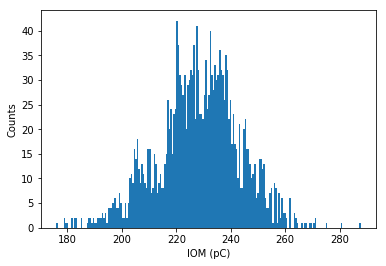

In [27]:
plt.hist(df["iom_intensity_pc"], bins=200)
plt.xlabel("IOM (pC)")
plt.ylabel("Counts")
plt.show()

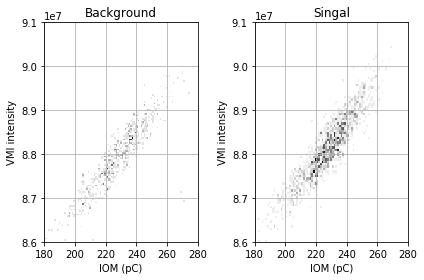

In [28]:
bg_period, bg_mod = 3, 0  # /Background_Period
df["is_bg"] = df["tag"] % bg_period == bg_mod
plt.figure()
plt.subplot(121)
where = df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[100, 100], cmap="Greys")
plt.title("Background")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.xlim(180, 280)
plt.ylim(8.6e7, 9.1e7)
plt.grid(True)

plt.subplot(122)
where = ~df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[100, 100], cmap="Greys")
plt.title("Singal")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.xlim(180, 280)
plt.ylim(8.6e7, 9.1e7)
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
ddf = (
    from_sequence(filenames)
    .map(read_img)
    .flatten()
    .to_dataframe()
    .merge(df, on="tag")
)
ddf

,img,tag,delay,img_intensity,iom_intensity_pc,is_bg
npartitions=20,,,,,,
,object,int64,float64,int64,float64,bool
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [32]:
where = True

with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg, 'delay': dt,
                'count': delayed(ddf[(ddf['is_bg'] == bg) & (ddf['delay'] == dt)]['img'].to_bag().count()),
                'summed': delayed(ddf[(ddf['is_bg'] == bg) & (ddf['delay'] == dt)]['img'].to_bag().sum()),
            }
            for bg in [True, False] for dt in df["delay"].unique()
        ],
    )

summed = pd.DataFrame(list(summed)).set_index(['delay', 'is_bg'])
summed

[########################################] | 100% Completed | 23.8s


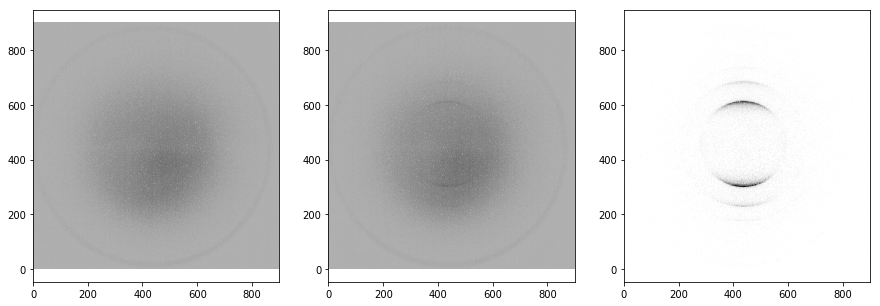

In [38]:
for k in df["delay"].unique():
    with File(f"{writein}/reduced_dt={k}.h5", "w") as f:
        f['bg_n'] = summed.loc[(k, True), 'count']
        f['bg_img'] = summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count']
        f['sg_n'] = summed.loc[(k, False), 'count']
        f['sg_img'] = summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count']
        f['df_n'] = summed.loc[(k, False), 'count']
        f['df_img'] = (
            summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count']
            - summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count']
        )

        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.pcolormesh(f['bg_img'], cmap="Greys")
        plt.clim(0, None)
        plt.axis('equal')
        plt.subplot(132)
        plt.pcolormesh(f['sg_img'], cmap="Greys")
        plt.clim(0, None)
        plt.axis('equal')
        plt.subplot(133)
        plt.pcolormesh(f['df_img'], cmap="Greys")
        plt.clim(0, None)
        plt.axis('equal')
        plt.show()